In [10]:
# notebook version of the spotfit code
#
import multicens2 
from astropy.io.fits import getdata
#import pyfits
import pandas as pd
import sys
import numpy as np

def magnitude(p,b):
    m=25.0 - 2.5*np.log10(p-b)
    return m


def spotfit(fname,fboxsize=7,nspots=1,WRITE_REGION_FILE=False,WRITE_CENTROID_FILE=False,VERBOSE=True):
    # the me, below are from fvchandler
    # don't change those numbers unless you know what you are doing
    max_counts = 2**16 - 1 # SBIC camera ADU max
    min_energy = 0.3 * 1.0 # this is the minimum allowed value for the product peak*fwhm for any given dot
    # now for the default settings
    '''
    Settings:
            fitboxsize: This is the size for the fitbox (in pixels). The spot needs to fall within this box
                        Select 7 for a typical FVC image. This will then use a 14 pixels x 14 pixels fitbox
                nspots: This is the maximum number of spots the fitter will look for. Set this larger than
                        the true number of spots to be on the safe side
                 fname: FITS filename
    '''
    fname_root=fname.lower()
    fname_root=fname_root.rstrip('.fits')
    fname_root=fname_root[-18:]
    #fname='peak_12548.4_fwhm_-0.338_sizefitbox_7.FITS'
    img=getdata(fname) 

    xCenSub, yCenSub, peaks, FWHMSub, flux, maxadu,filename = multicens2.multiCens(img, 
                n_centroids_to_keep=nspots, verbose=False, write_fits=False,size_fitbox=fboxsize)
    # we are calculating the quantity 'FWHM*peak' with peak normalized to the maximum peak level. This is
    # esentially a linear light density. We will call this quantity 'energy' to match Joe's naming in fvchandler.
    # We verified that the linear light density is insensitive to spot position whereas the measured peak is not.
    energy=[FWHMSub[i]*(peaks[i]/max_counts) for i in range(len(peaks))]
    if VERBOSE:
        print(" File: "+str(fname))
        print(" Number of centroids requested: "+str(nspots))
        print(" Fitboxsize: "+str(fboxsize))
        print(" Centroid list:")  
        print(" Spot  x         y          FWHM    Peak     flux  ")
    # sort by peak value
    sindex=sorted(range(len(peaks)), key=lambda k: peaks[k])

    peaks_sorted=[peaks[i] for i in sindex]
    x_sorted=[xCenSub[i] for i in sindex]
    y_sorted=[yCenSub[i] for i in sindex]
    fwhm_sorted=[FWHMSub[i] for i in sindex]
    energy_sorted=[flux[i] for i in sindex]
    maxadu_sorted=[maxadu[i] for i in sindex]

    if VERBOSE:
        for i, x in enumerate(x_sorted):
            line=("{:5d} {:9.3f} {:9.3f} {:6.2f}  {:7.0f} {:7.2f} {:7.0f}".format(i, x, y_sorted[i], fwhm_sorted[i], 
                peaks_sorted[i], energy_sorted[i], maxadu_sorted[i]))
            print(line)
        print("Min peak   : {:8.2f} ".format(min(peaks_sorted)))
        print("Max peak   : {:8.2f} ".format(max(peaks_sorted)))
        print("Mean peak  : {:8.2f} ".format(np.mean(peaks_sorted)))
        print("Sigma peak : {:8.2f} ".format(np.std(peaks_sorted)))
    print(str(len(x_sorted))+" centroids found")    
    # write region file
    if WRITE_REGION_FILE==True:    
        with open(fname_root+'.reg','w') as fp:
            for i, x in enumerate(x_sorted):
                #print("{:5d} {:9.3f} {:9.3f} {:7.3f}   {:9.3f} {:9.3f}   {:7.3f} ".format(i, x, yCenSub[i], FWHMSub[i], peaks[i], bias[i],magnitude(peaks[i],bias[i])))
                fp.write('circle '+ "{:9.3f} {:9.3f} {:7.3f} \n".format(x+1, y_sorted[i]+1, fwhm_sorted[i]/2.))
                text='"'+str(i)+'"'
                fp.write('text '+ "{:9.3f} {:9.3f} {:s} \n".format(x+1+5, y_sorted[i]+1+5, text))
    
    if WRITE_CENTROID_FILE==True:    
        with open(fname_root+'.cen','w') as fp:
            for i, x in enumerate(x_sorted):
                line=("{:5d} {:9.3f} {:9.3f} {:6.2f}  {:7.0f} {:7.2f}  {:7.0f} ".format(i, x, y_sorted[i], fwhm_sorted[i], peaks_sorted[i], energy_sorted[i],maxadu_sorted[i]))
                fp.write(line+'\n')
                
    DF = pd.DataFrame(columns=['num','cenx','ceny','fwhm','peak','flux','maxadu']) 
    for i, x in enumerate(x_sorted):
        line=[i, x, y_sorted[i], fwhm_sorted[i], peaks_sorted[i], energy_sorted[i],maxadu_sorted[i]]
        DF.loc[i] = line    
    return DF
          




 fit failed - trying again with smaller fitbox
 fit failed - trying again with smaller fitbox
 fit failed - trying again with smaller fitbox
 fit failed - trying again with smaller fitbox
 fit failed - trying again with smaller fitbox
 fit failed - trying again with smaller fitbox
49 centroids found


<IPython.core.display.Javascript object>


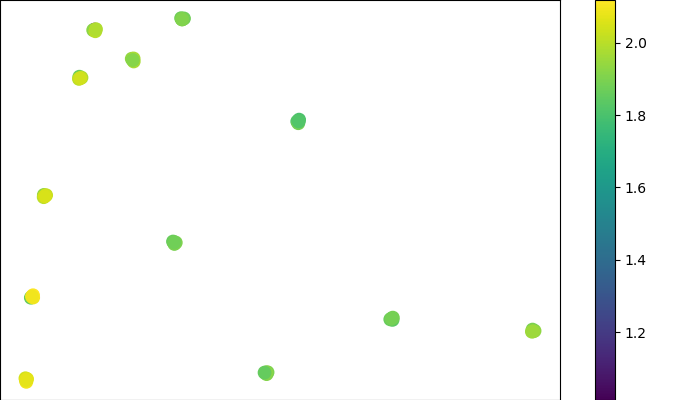

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
# create the .cen files like so:
# python3 spotfit2.py 543 /home/schubnel/data/fvc.20190130165312.fits
#
# the following files have 542 spots
'''
Illuminatian by panel:
20190204172348: centered white light
20190204172446: cnetered again
20190204172609: phi cw 30
20190204172727: theta cw 30
20190204173003.fits: back to center
'''
fname='/home/schubnel/desi/data/images/fvc2/fvc.20190220110430.fits'
df1=spotfit(fname,fboxsize=7,nspots=550,WRITE_REGION_FILE=False,WRITE_CENTROID_FILE=False,VERBOSE=False)

xvals=df1['cenx']
yvals=df1['ceny']
flux=df1['flux']
maxadu=df1['maxadu']
fwhm=df1['fwhm']

fig=plt.figure(figsize = (7,4)) #14,7
ax=fig.add_axes(fig.add_axes([0,0,1,1]))
sc=ax.scatter(xvals,yvals,s=80,c=fwhm)
plt.colorbar(sc)
#print(positioners)
  
plt.show()